# **Chapter 3 - Sampling the Imaginary**

In [1]:
import os
import sys
import warnings
module_path = os.path.abspath(os.path.join("../.."))
if module_path not in sys.path:
    sys.path.append(module_path)

In [2]:
import arviz as az
import numpy as np
import pymc3 as pm

from matplotlib import pylab as plt
from scipy import stats

In [3]:
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)

%config InlineBackend.figure_format = 'retina'
%load_ext watermark
az.style.use("arviz-darkgrid")

In [20]:
def posterior_grid_approx(n_p_grid=5, success=6, tosses=9, method='uniform'):
    
    # define the parameter grid
    p_grid = np.linspace(0, 1, n_p_grid)

    # define prior
    if method=='uniform':
        prior = np.repeat(5, n_p_grid)
    elif method=='truncated':
        prior = (p_grid >= 0.5).astype(int)
    elif method=='double_exp':
        prior = np.exp(- 5 * abs(p_grid - 0.5))

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(success, tosses, p_grid)

    # compute product of likelihood and prior
    unstd_posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior = unstd_posterior / unstd_posterior.sum()
    return p_grid, posterior

All of this chapter depends on the posterior distribution for the globe spinning example. I will implement pymc3 to do most of the leg work for me. As before, set the prior to be the uniform and the likelihood to be the binomial. The data given in the book is the set of outcomes W L W W W L W L W, which I'll give a binary representation in the same order.

Pymc3 nicely allows you to state the prior and the likelihood function of the data. You can use its pm.sample function in order to obtain a random sample from the posterior distribution. This is done using MCMC techniques, but they aren't introduced until later in Statistical rethinking. You can run "chains" of the sampling procedure to sanity check the MCMC methods that took place. The samples from the posterior distribution are also returned and we can perform inference on the posterior according to this.

In [4]:
data = np.array([1, 0, 1, 1, 1, 0, 1, 0, 1])

/home/starscream/anaconda3/envs/stat_rethinking/lib/python3.9/site-packages/deprecat/classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


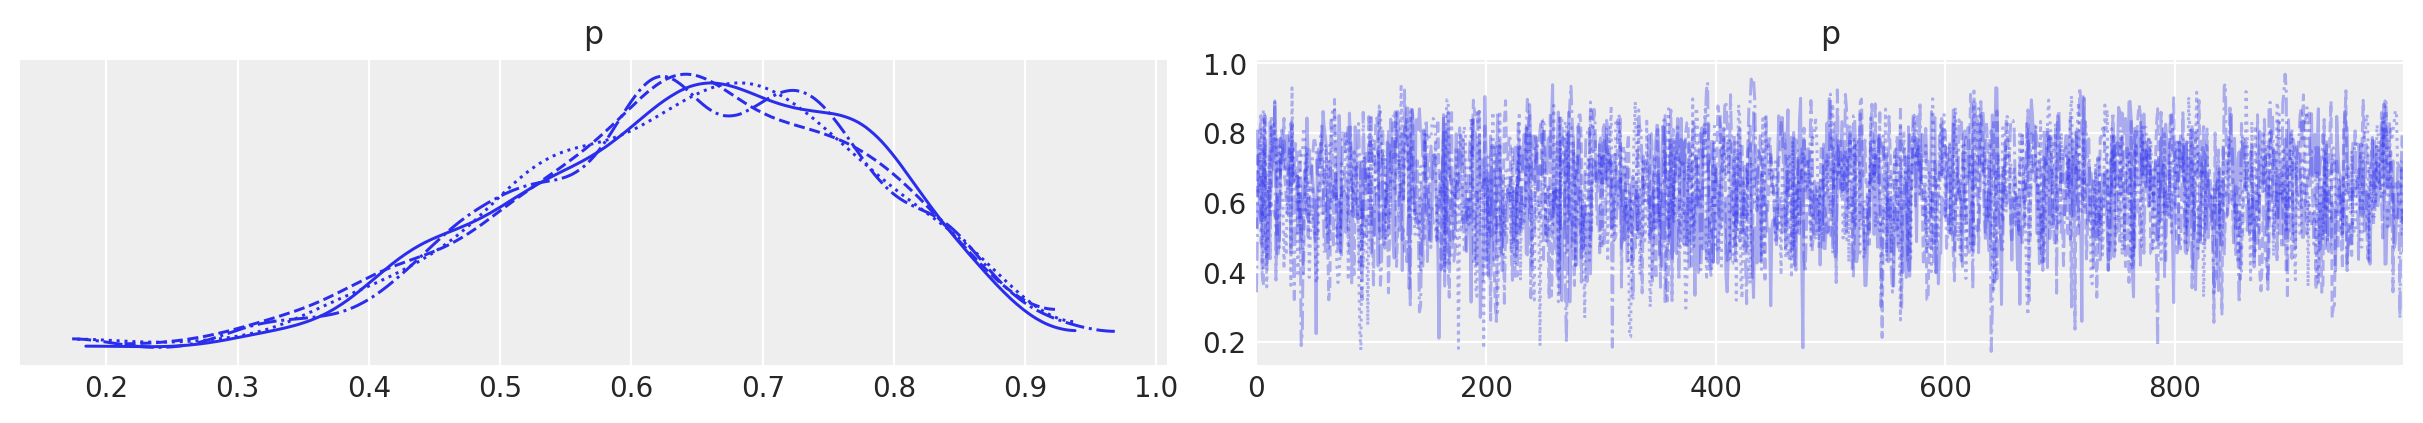

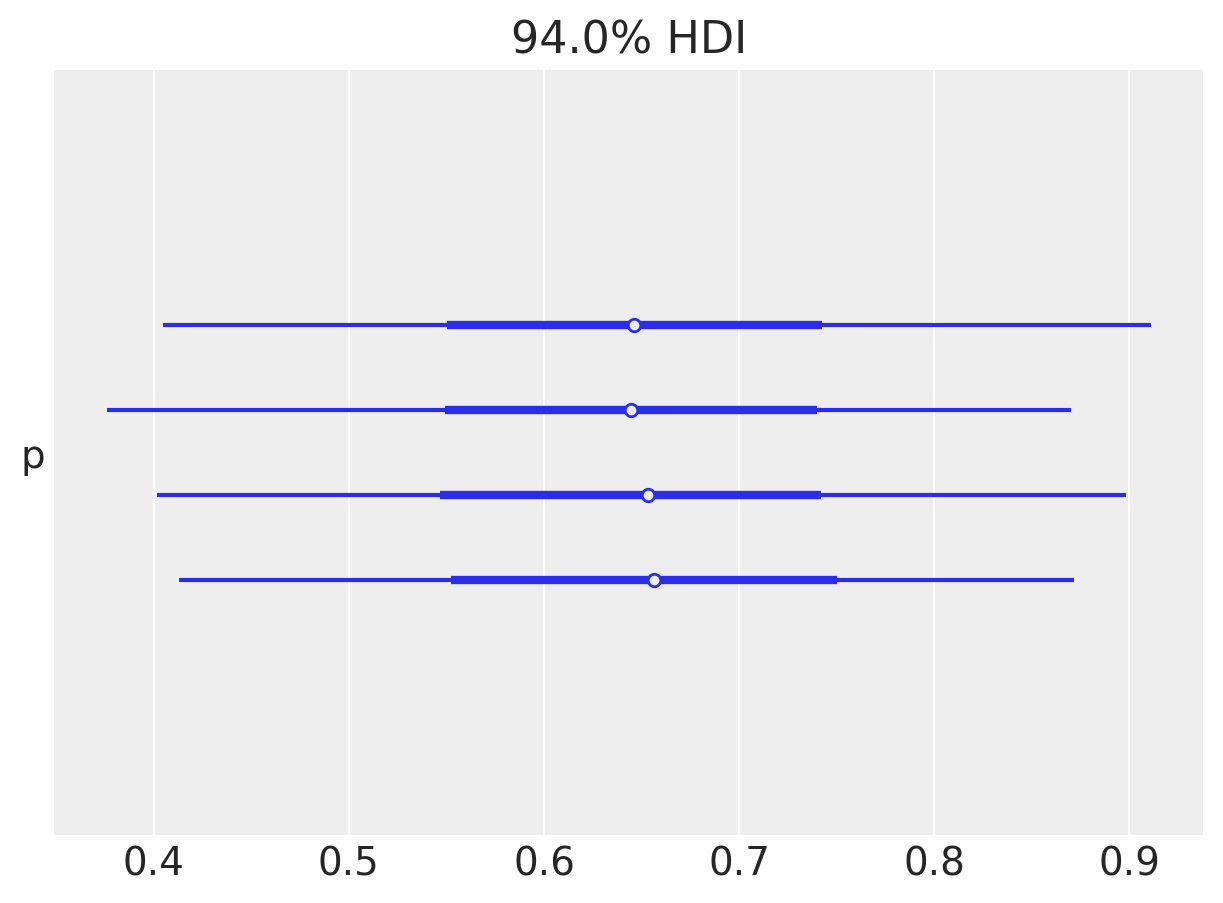

In [5]:
with pm.Model() as our_first_model:
    p = pm.Uniform("p")  # set the prior
    y = pm.Bernoulli("y", p=p, observed=data)  # set the posterior
    trace = pm.sample(1000, chains=4)  # get 1000 random_samples
    az.plot_trace(trace)
    az.plot_forest(trace, var_names=["p"])

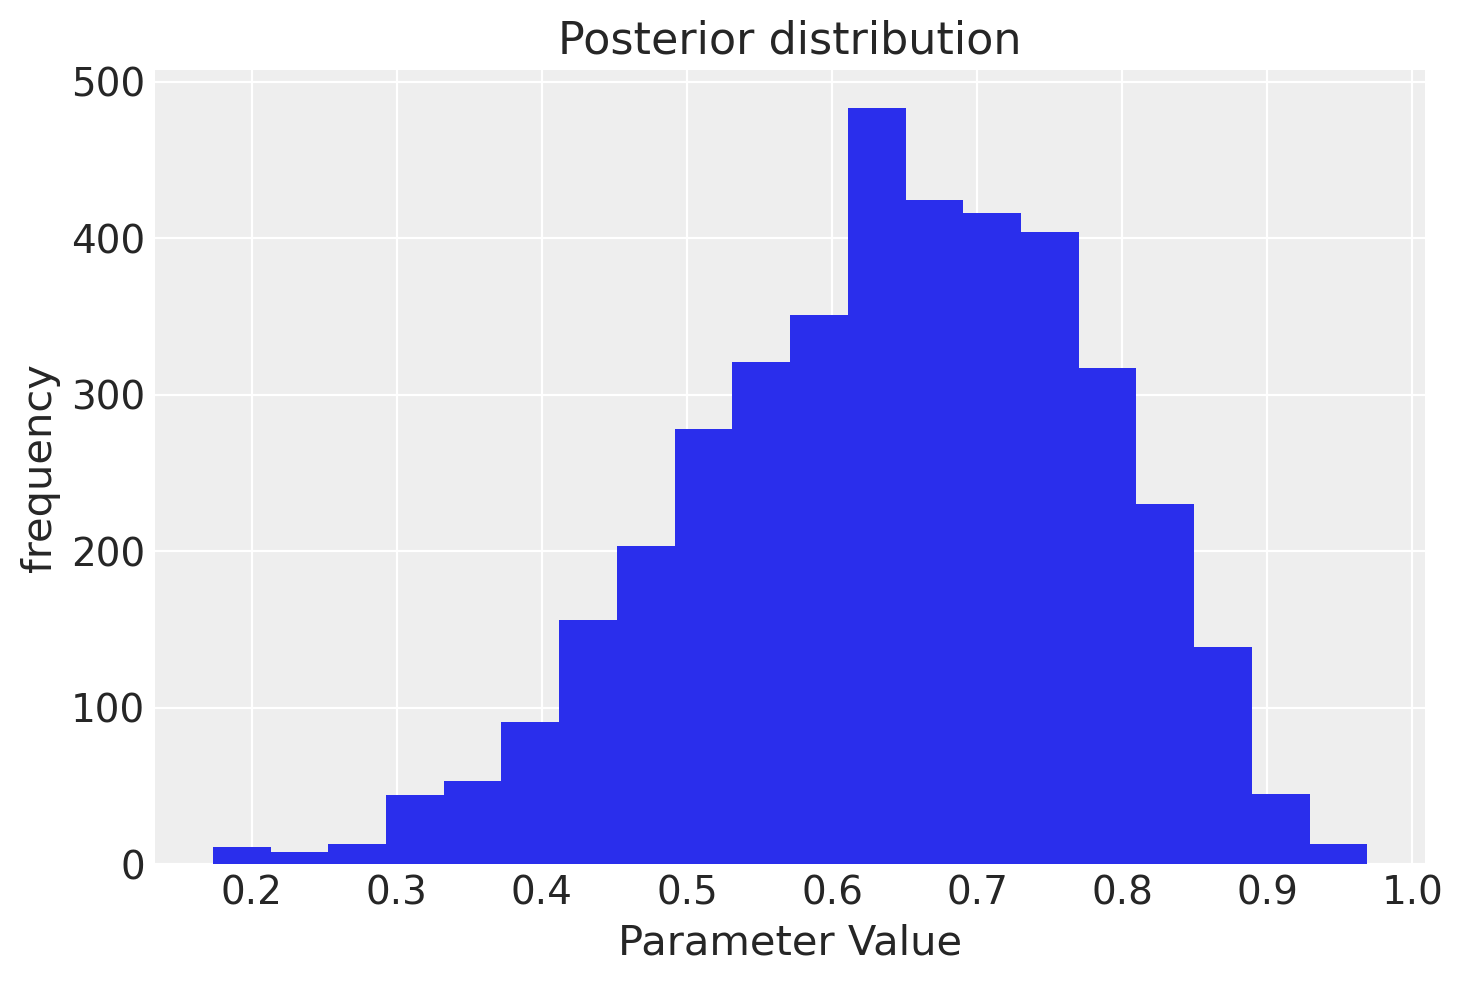

In [6]:
# plot the posterior
plt.hist(trace["p"], bins=20)
plt.title("Posterior distribution")
plt.ylabel("frequency")
plt.xlabel("Parameter Value");

### **3E1.**
How much posterior probability lies below p = 0.2?

In [7]:
samples = trace["p"]
print(str(np.sum(samples < 0.2) / samples.size) + " of the posterior lies below 0.2")

0.0025 of the posterior lies below 0.2


### **3E2.**
How much posterior probability lies above p = 0.8?

In [9]:
print(str(np.sum(samples > 0.8) / samples.size) + " of the posterior lies above 0.8")

0.12325 of the posterior lies above 0.8


### **3E3.**
How much posterior probability lies between p = 0.2 and p = 0.8?

There are two ways to compute this. You can either do $1 - P_{<0.2} - P_{>0.8}$ or you can re_compute the interval. These are implemented in the respective order.

In [10]:
print(
    str(1 - np.sum(samples > 0.8) / samples.size - np.sum(samples < 0.2) / samples.size)
    + " of the posterior lies between 0.2 & 0.8"
)

0.8742500000000001 of the posterior lies between 0.2 & 0.8


In [11]:
print(
    str(np.sum((samples < 0.8) & (samples > 0.2)) / samples.size)
    + " of the posterior lies above 0.8"
)

0.87425 of the posterior lies above 0.8


Thankfully, they are both in agreement.

### **3E4.**
20% of the posterior probability lies below which value of p?

In [12]:
print("The 20% quantile of the posterior is " + str(np.quantile(samples, 0.2)))

The 20% quantile of the posterior is 0.5245596917191309


### **3E5.**
20% of the posterior probability lies above which value of p?

This is just the 80% quantile

In [11]:
print("20% of the probability mass lies above " + str(np.quantile(samples, 0.8)))

20% of the probability mass lies above 0.7641845415047686


### **3E6.**
Which values of p contain the narrowest interval equal to 66% of the posterior probability?

arviz has a function to help us compute the highest density posterior interval.

In [13]:
hpd_interval = az.hdi(samples, hdi_prob=0.66)
print(hpd_interval)

[0.52726678 0.79358387]


Sanity checking this, it's seen that the interval does in fact contain around 66% of the mass

In [14]:
print(
    str(
        1
        - np.sum(samples > hpd_interval[1]) / samples.size
        - np.sum(samples < hpd_interval[0]) / samples.size
    )
)

0.66025


### **3E7.**
Which values of p contain 66% of the posterior probability, assuming equal posterior probability both below and above the interval?

In [17]:
p_i = 66
p_i_vals = np.percentile(samples, [(100-p_i)/2, p_i+(100-p_i)/2])
p_i_vals

array([0.50799338, 0.77756229])

This is very similar to the 66% hpd interval found earlier. As this posterior is relatively bell curved, and has reasonable amount of symmetry to it, this similarity between these two central intervals isn't too surprising.

### **3M1.**
Suppose the globe tossing data had turned out to be 8 water in 15 tosses. Construct the posterior distribution, using grid approximation. Use the same flat prior as before

I'm going to recycle the code from earlier

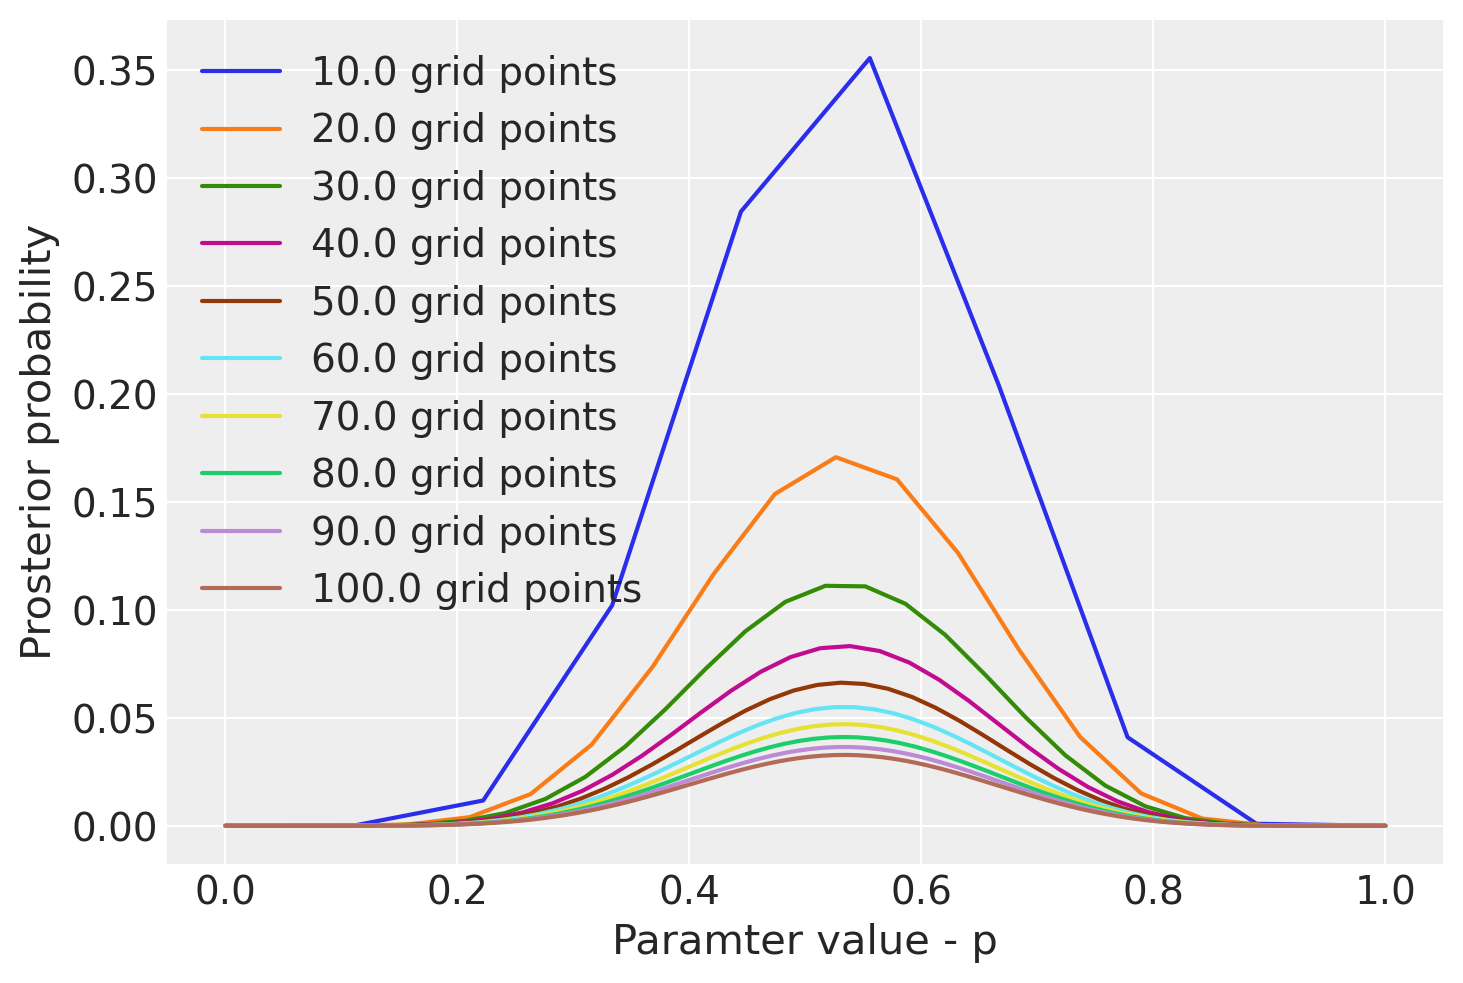

In [21]:
w, n = 8, 15
for points in np.linspace(10, 100, 10):
    p_grid, posterior = posterior_grid_approx(n_p_grid = int(points), success=w, tosses=n, method='uniform')
    plt.plot(p_grid, posterior, label=str(points) + " grid points")

plt.xlabel("Paramter value - p")
plt.ylabel("Prosterior probability")
plt.legend();

This produces a much more symmetrical distribution of the data for us to work with.

### **3M2.**
Draw 10,000 samples from the grid approximation from above. Then use the samples to calculate the 90% HPDI for p

Let's use the distribution found for 100 grid points as there seems to be reasonable convergence in the distributions at that number of grid points. The variable post will be set to the posterior distribution for 100 grid points as this was the last place in the for loop ran above so we can just sample from it.

In [22]:
# sample from the grid points in accordance with the weights of the probabilities assigned by the posterior
samples = np.random.choice(p, size=10000, replace=True, p=post)

In [23]:
# obtain the HPDI for the sample from the grid posterior
az.hdi(samples)

array([0.31313131, 0.74747475])

### **3M3.**
Construct a posterior predictive check for this model and data. This means simulate the distribution of samples, averaging over the posterior uncertainty in p. What is the probability of observing
8 water in 15 tosses?

So we have samples from our posterior distribution. Each of these samples represents a parameter value, and each parameter value should appear in the sample in accordance with the likelihood accorded it by the posterior. For each sample's parameter value, we can produce data, as if it were produced from a binomial distribution with that parameter value. This can be very easily implemented in numpy as follows

In [24]:
# construct the posterior predictive distribution
ppd = np.random.binomial(n=15, p=samples)

In [25]:
ppd.shape

(10000,)

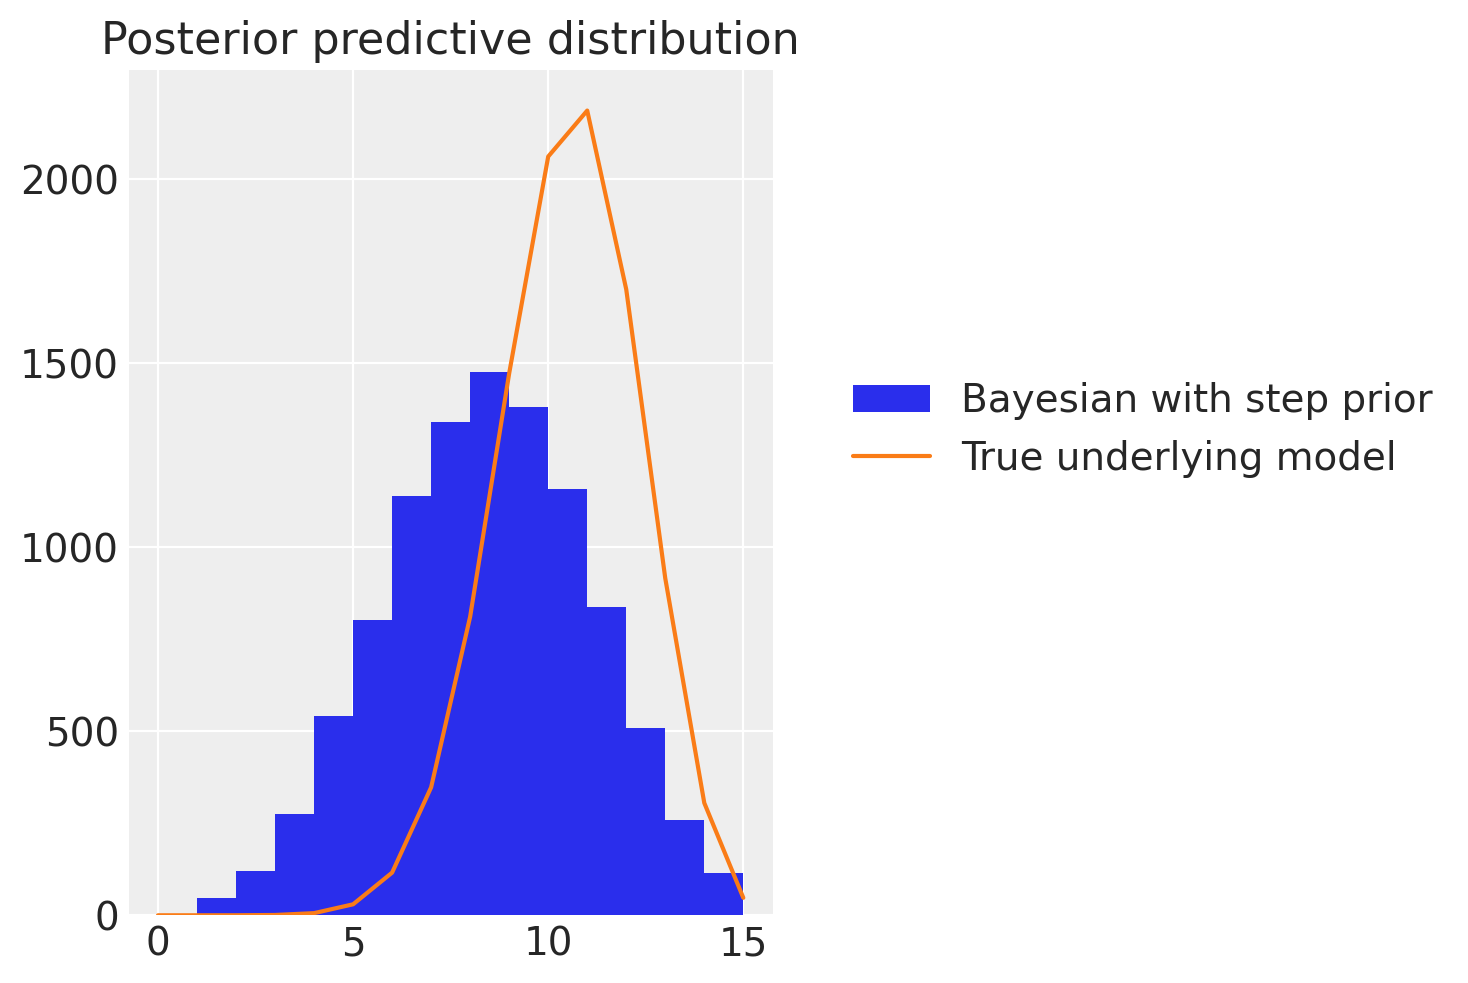

In [26]:
plt.hist(ppd, bins=15, label="Bayesian with step prior")
plt.plot(
    np.linspace(0, 15, 16),
    10000 * stats.binom.pmf(np.linspace(0, 15, 16), n=15, p=0.7),
    label="True underlying model",
)
plt.title("Posterior predictive distribution")
plt.legend(loc=(1.1, 0.5));

This looks fairly consistent with the data, and the posterior would predict the data that we actually saw.

### **3M4.**
Using the posterior distribution constructed from the new (8/15) data, now calculate the probability of observing 6 water in 9 tosses.

I take this to mean, given that we just observed 8/15 in our first data set, what probability do we assign to see 6/15 on another trial of 15 tosses of the globe

In [27]:
print("probability of 6 waters on the next trial " + str(np.sum(ppd == 6) / ppd.shape))

probability of 6 waters on the next trial [0.1138]


### **3M5.**
Start over at 3M1, but now use a prior that is zero below p = 0.5 and a constant above p = 0.5.
This corresponds to prior information that a majority of the Earth’s surface is water. Repeat each
problem above and compare the inferences. What difference does the better prior make? If it helps,
compare inferences (using both priors) to the true value p = 0.7

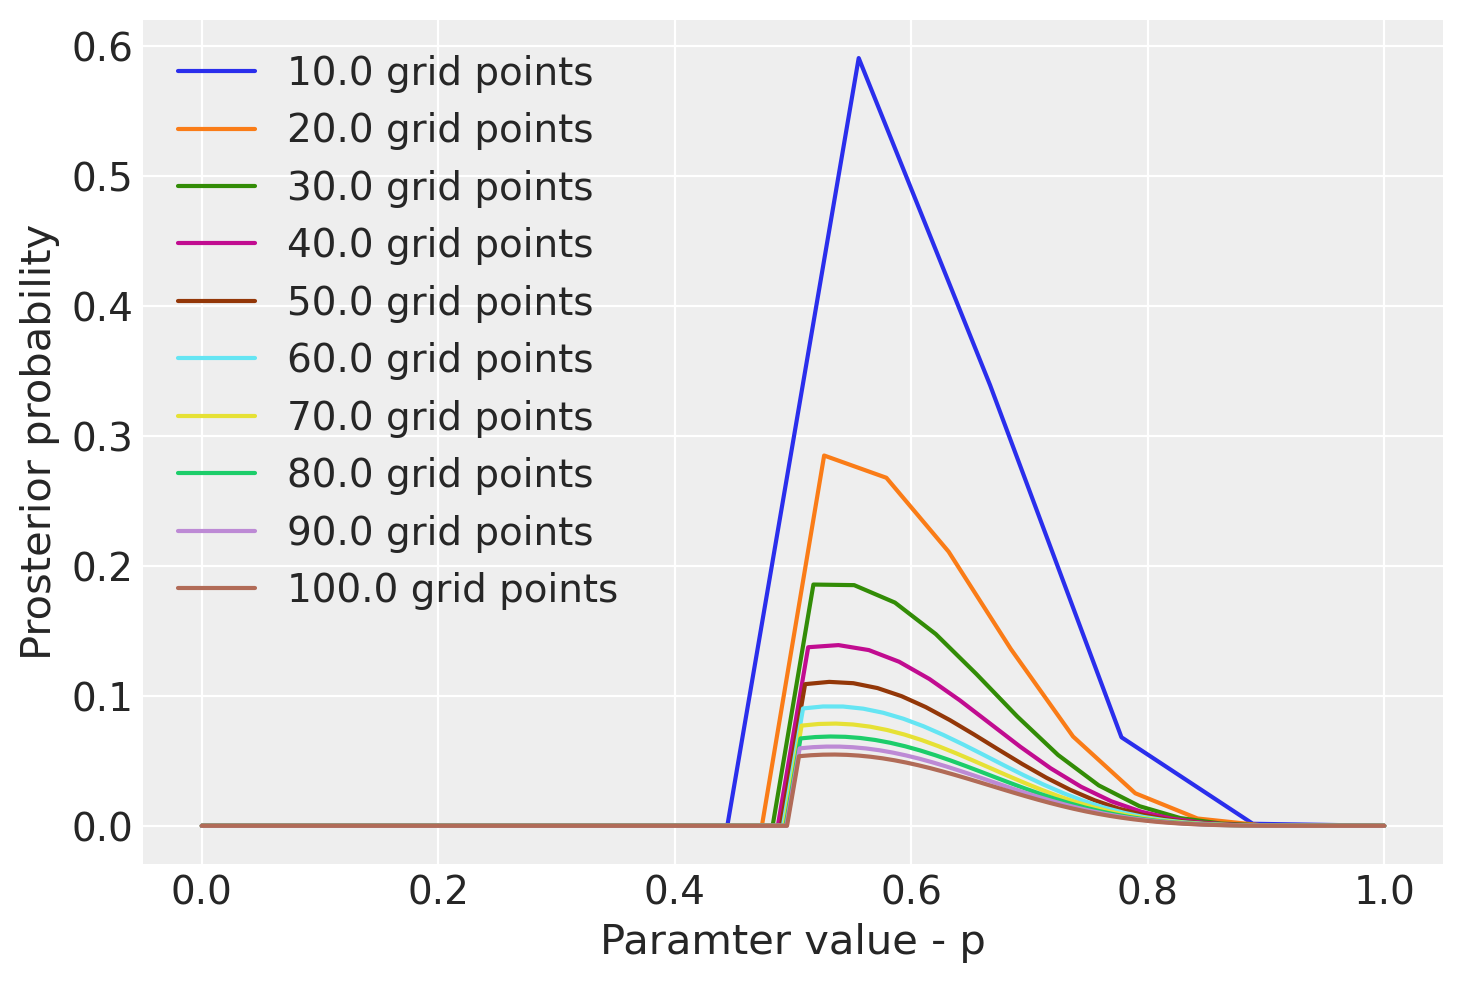

In [28]:
w, n = 8, 15
for points in np.linspace(10, 100, 10):
    p_grid, posterior = posterior_grid_approx(n_p_grid = int(points), success=w, tosses=n, method='truncated')
    plt.plot(p_grid, posterior, label=str(points) + " grid points")

plt.xlabel("Paramter value - p")
plt.ylabel("Prosterior probability")
plt.legend();

The step prior also induces a step into the posterior distribution.

Draw 10,000 samples from the grid approximation from above. Then use the samples to calculate the 90% HPDI for p

Let's use the distribution found for 100 grid points as there seems to be reasonable convergence.

In [29]:
# sample from the grid points in accordance with the weights of the probabilities assigned by the posterior
samples = np.random.choice(p, size=10000, replace=True, p=post)

In [30]:
# obtain the HPDI for the sample from the grid posterior
az.hdi(samples, hdi_prob=0.9)

array([0.34343434, 0.72727273])

Construct a posterior predictive check for this model and data. This means simulate the distribution of samples, averaging over the posterior uncertainty in p. What is the probability of observing
8 water in 15 tosses?

In [31]:
# construct the posterior predictive distribution
ppd = np.random.binomial(n=15, p=samples)

In [32]:
ppd.shape

(10000,)

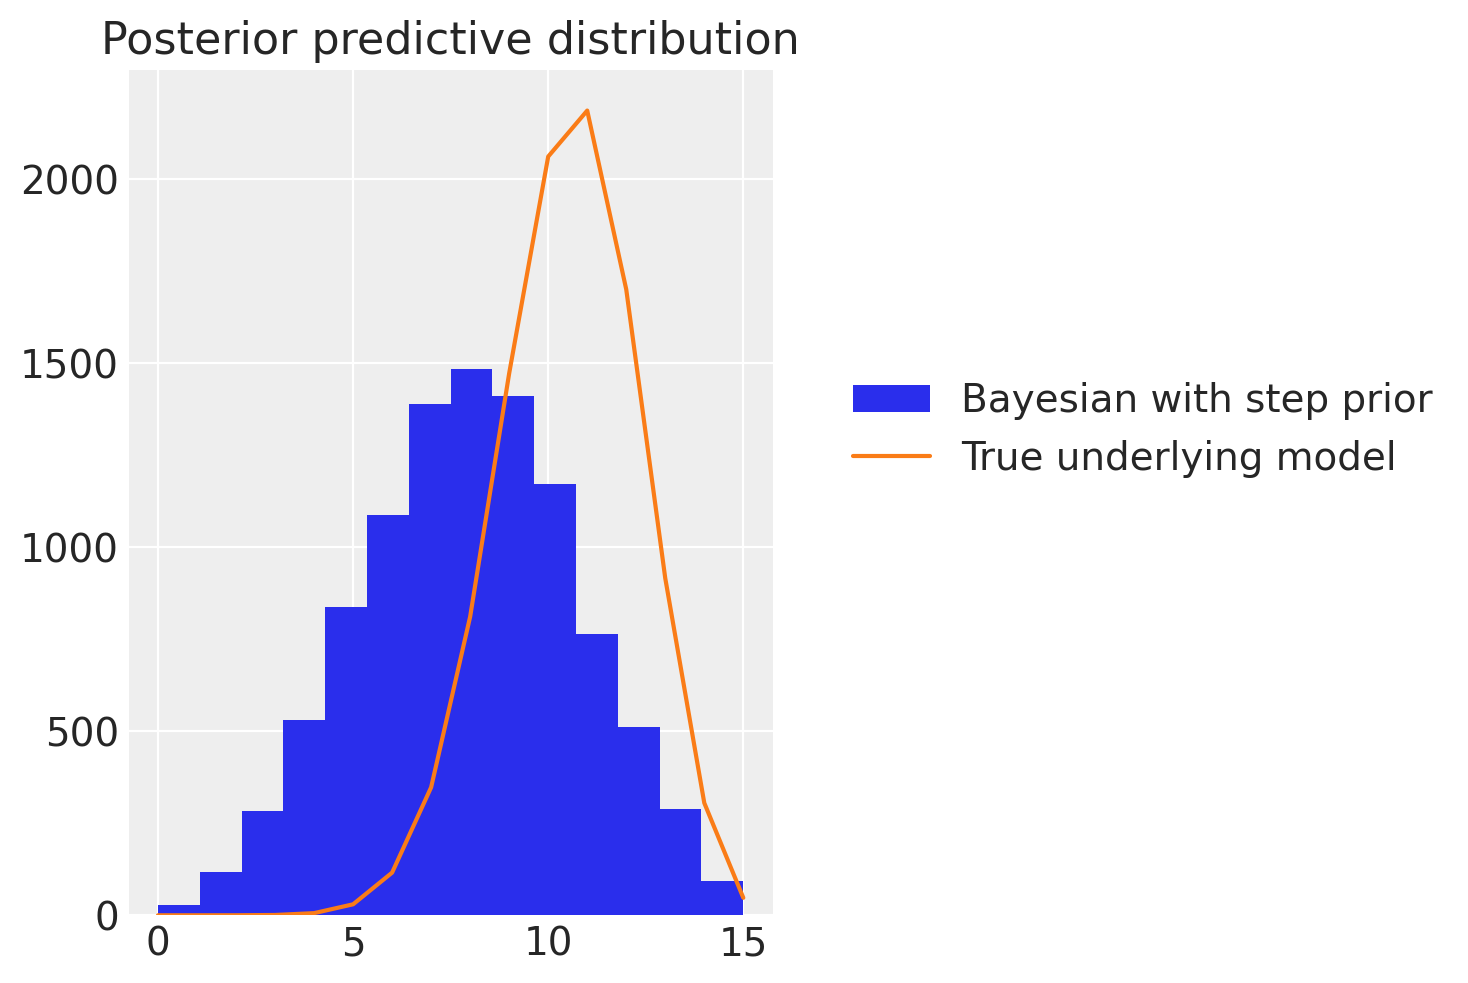

In [33]:
plt.hist(ppd, bins=14, label="Bayesian with step prior")
plt.plot(
    np.linspace(0, 15, 16),
    10000 * stats.binom.pmf(np.linspace(0, 15, 16), n=15, p=0.7),
    label="True underlying model",
)
plt.title("Posterior predictive distribution")
plt.legend(loc=(1.1, 0.5));

It can be seen that the posterior predictive distribution and the final confidence intervals are much much narrower than for the previous model, and centre is much closer to the true value of 0.7. Additionally, the predictions of the future data were more in line with what would be expected for the true parameter value of 0.7. Using a more reasonable prior than the uniform prior can really improve predictive power in the future. The point is you should incorporate any domain knowledge you have into the prior where possible.

### **3M6.**

Suppose you want to estimate the Earth’s proportion of water very precisely. Specifically, you
want the 99% percentile interval of the posterior distribution of p to be only 0.05 wide. This means
the distance between the upper and lower bound of the interval should be 0.05. How many times will
you have to toss the globe to do this?

For this we can perform a simulation study. Let's assume we have the uniform prior on our model, and that the data has a binomial likelihood, as in the earlier questions. We can simulate data according to true underlying values of p. We can keep tossing the globe until our 99% percentile intervals have a width smaller than 0.05, at which point we'll stop tossing, and take note of how many trials it took for the intervals to converge. As this number of trials is going to be stochastic for each run, we repeat the runs 100 times and take the mean of the number trials to get an estimate of the number of trials required. We then repeat this for different hypothetical values of the underlying parameter p, to see how the number of trials required varies with the parameter.

In [34]:
grid = np.linspace(0, 1, 10)  # define a grid of ground truth values

trials_for_p = []

for p in grid:
    num_trials = []
    for i in range(100):
        n, x = 0, 0  # initialise # samples and #successful trials
        interval = (0.005, 0.995)  # initialise the interval to the flat prior
        while interval[1] - interval[0] > 0.05:
            x += np.random.binomial(1, p)  # perform trial
            n += 1  # add counts
            interval = stats.beta.interval(0.99, x + 1, n - x + 1)  # percential interval
        num_trials.append(n)
    mean = np.array(num_trials).mean()
    trials_for_p.append(mean)

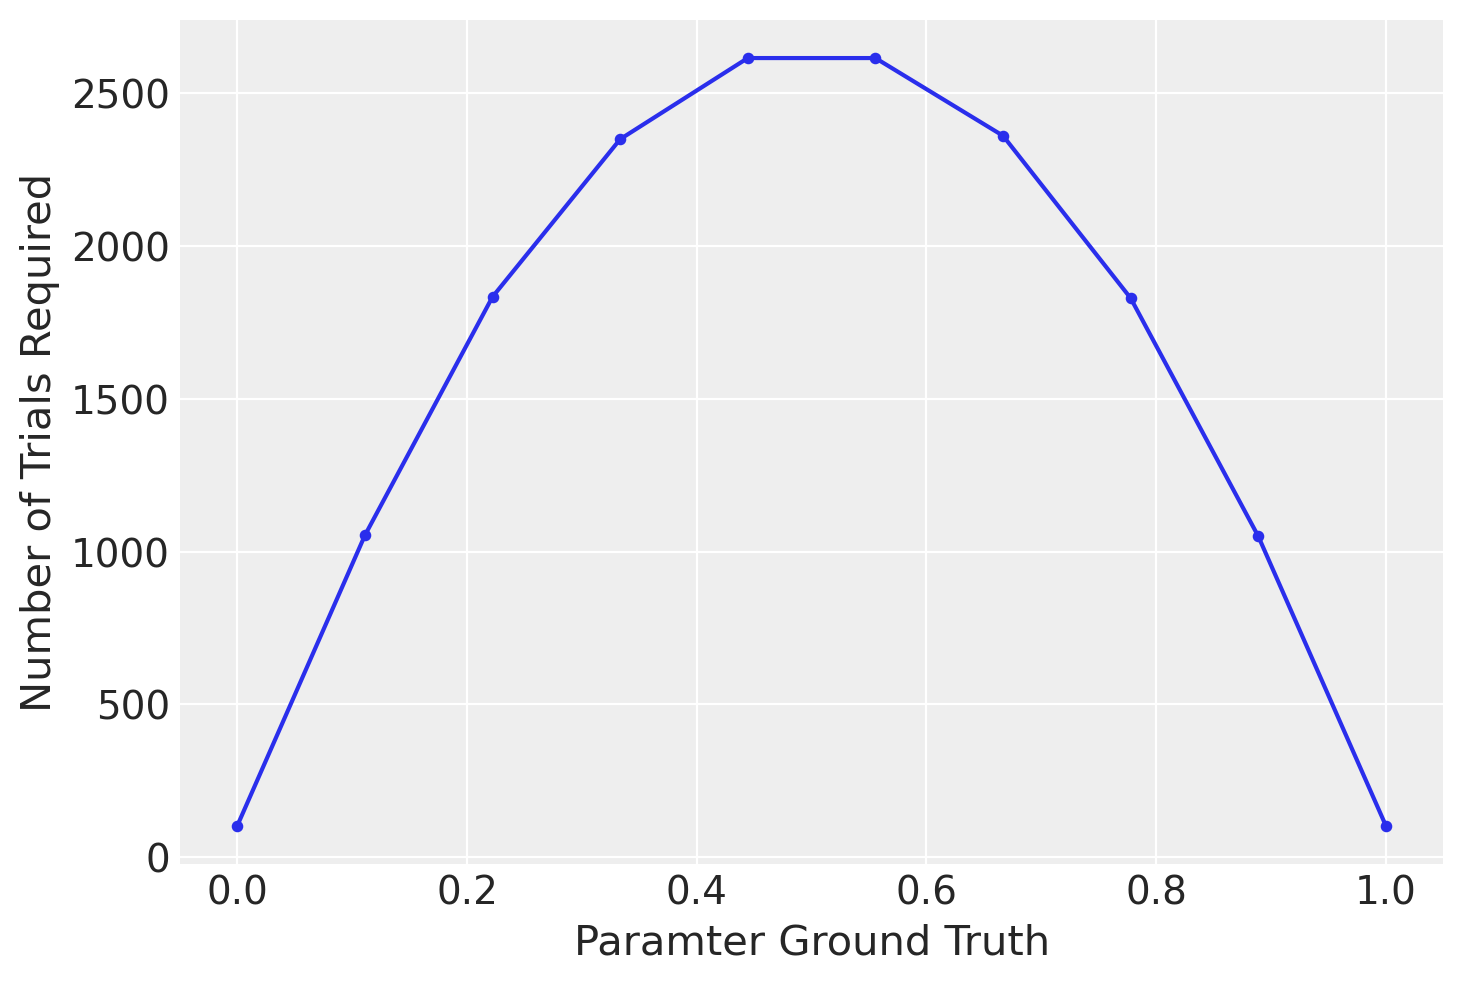

In [35]:
plt.plot(grid, trials_for_p)
plt.scatter(grid, trials_for_p, s=10)
plt.ylabel("Number of Trials Required")
plt.xlabel("Paramter Ground Truth");

### **Hard.**
The Hard problems here all use the data below. These data indicate the gender (male=1, female=0) of officially reported first and second born children in 100 two-child families.


In [38]:
# fmt: off
birth_1 = np.array([1,0,0,0,1,1,0,1,0,1,0,0,1,1,0,1,1,0,0,0,1,0,0,0,1,0,
0,0,0,1,1,1,0,1,0,1,1,1,0,1,0,1,1,0,1,0,0,1,1,0,1,0,0,0,0,0,0,0,
1,1,0,1,0,0,1,0,0,0,1,0,0,1,1,1,1,0,1,0,1,1,1,1,1,0,0,1,0,1,1,0,
1,0,1,1,1,0,1,1,1,1])
birth_2 = np.array([0,1,0,1,0,1,1,1,0,0,1,1,1,1,1,0,0,1,1,1,0,0,1,1,1,0,
1,1,1,0,1,1,1,0,1,0,0,1,1,1,1,0,0,1,0,1,1,1,1,1,1,1,1,1,1,1,1,1,
1,1,1,0,1,1,0,1,1,0,1,1,1,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,1,
0,0,0,1,1,1,0,0,0,0])
# fmt: on

In [46]:
birth_1.size, birth_2.size

(100, 100)

### **3H1.**
Using grid approximation, compute the posterior distribution for the probability of a birth
being a boy. Assume a uniform prior probability. Which parameter value maximizes the posterior
probability?

I'll do this with 1,000 grid points to improve the precision of the posterior

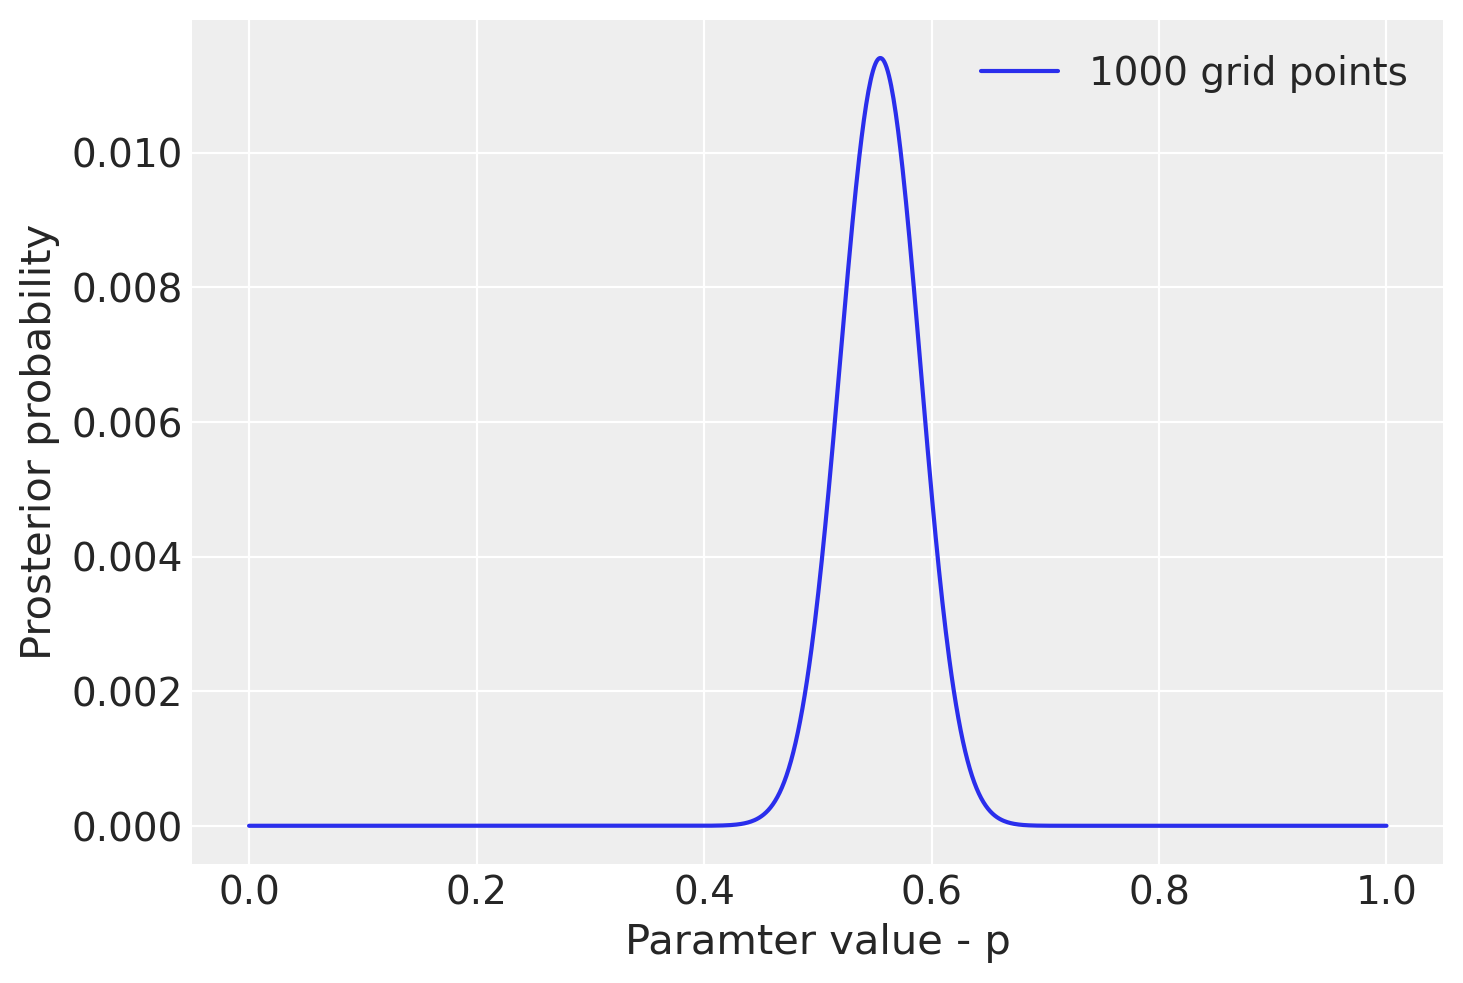

In [45]:
# get the number of boys
num_boys = np.sum(birth_1) + np.sum(birth_2)
num_total = birth_1.size + birth_2.size

n_p_grid = 1000
p_grid, posterior = posterior_grid_approx(n_p_grid = n_p_grid, success=num_boys, tosses=num_total, method='uniform')
plt.plot(p_grid, posterior, label=str(1000) + " grid points")

plt.xlabel("Paramter value - p")
plt.ylabel("Prosterior probability")
plt.legend();

In [47]:
# find value of numpy array with max value
p_grid[np.argmax(posterior)]

0.5545545545545546

### **3H2.**
Using the sample function, draw 10,000 random parameter values from the posterior distribution you calculated above. Use these samples to estimate the 50%, 89%, and 97% highest posterior
density intervals.

In [48]:
# sample from the posterior
post_sample = np.random.choice(p_grid, replace=True, size=10000, p=posterior)

In [49]:
# use pymc to find the hpdi
print("50% HPDI " + str(az.hdi(post_sample, 0.5)))
print("89% HPDI " + str(az.hdi(post_sample, 0.89)))
print("97% HPDI " + str(az.hdi(post_sample, 0.97)))

50% HPDI [0.53053053 0.57657658]
89% HPDI [0.4964965  0.60660661]
97% HPDI [0.47947948 0.62762763]


As there's a lot of samples in this data set, a considerable amount of probability mass has been concentrated onto a narrow range. Hence the HPDIs don't exhibit huge changes with change in the amount of probability mass included within the interval. Nicely, within the 97% HPDI is the value of p=0.5, which would mean equal probability of having a boy or a girl which matches the conventional wisdom.

### **3H3.**
Use rbinom to simulate 10,000 replicates of 200 births. You should end up with 10,000 numbers, each one a count of boys out of 200 births. Compare the distribution of predicted numbers
of boys to the actual count in the data (111 boys out of 200 births). There are many good ways to
visualize the simulations, but the dens command (part of the rethinking package) is probably the
easiest way in this case. Does it look like the model fits the data well? That is, does the distribution
of predictions include the actual observation as a central, likely outcome?

I take this question to mean, using the 10,000 samples from the posterior distribution that you just obtained, produce a random sample from the posterior predictive distribution of future births.

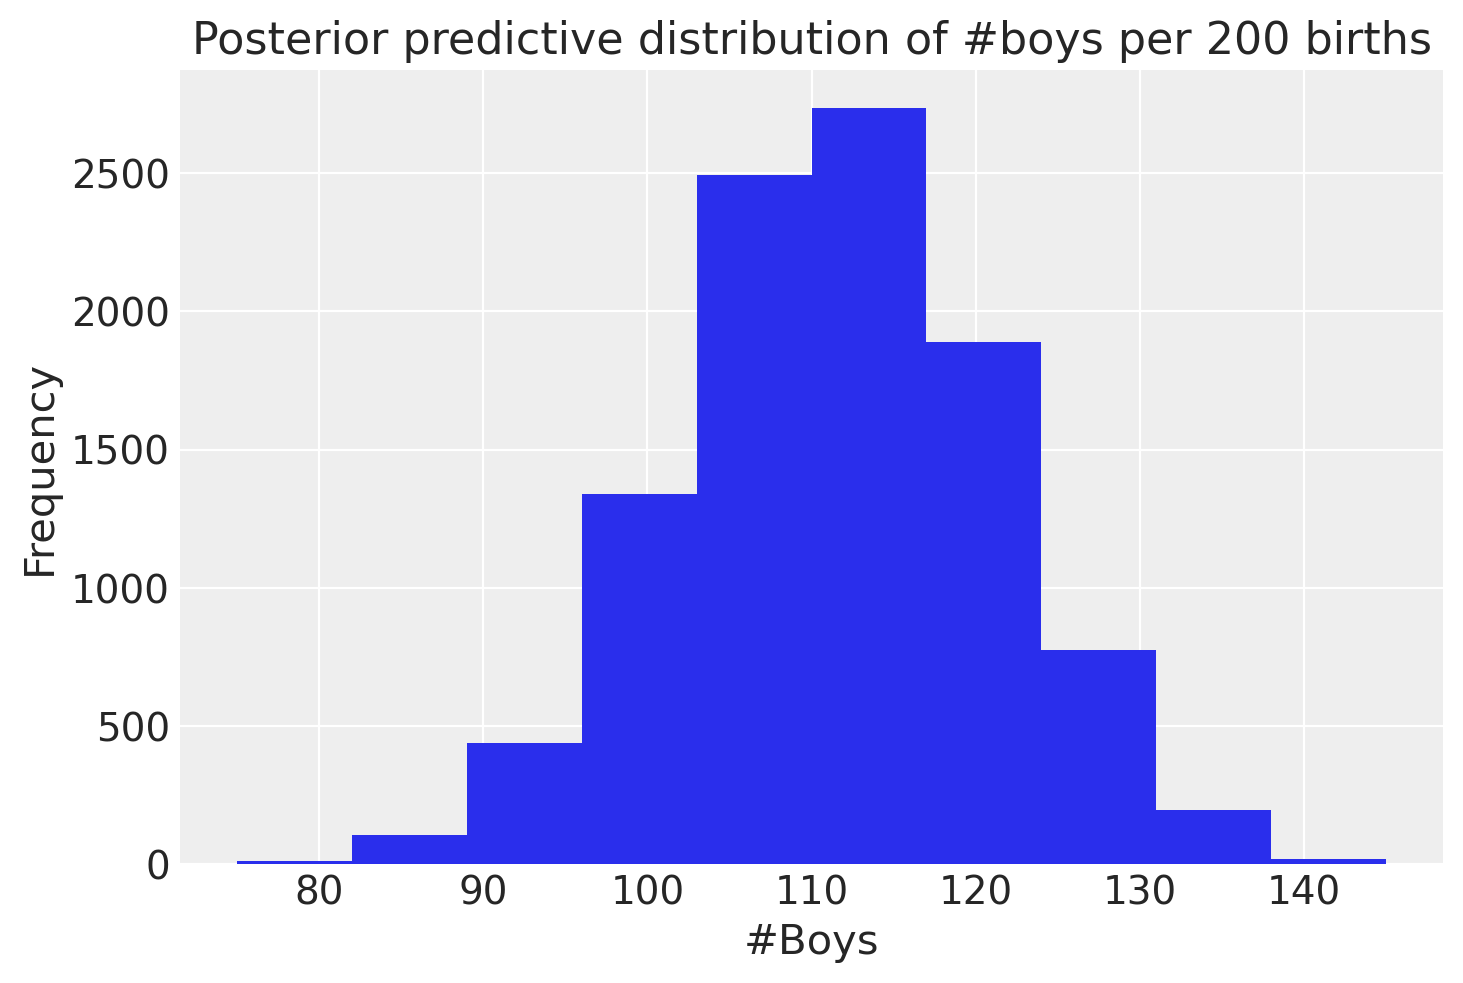

In [50]:
ppd = np.random.binomial(n=200, p=post_sample)
plt.hist(ppd)
plt.title("Posterior predictive distribution of #boys per 200 births")
plt.xlabel("#Boys")
plt.ylabel("Frequency");

Given that there were 111 boys given birth to in the actual data, the posterior predictive distribution from the model appears to be consistent with observations.

### **3H4.**
Now compare 10,000 counts of boys from 100 simulated first borns only to the number of boys
in the first births, birth1. How does the model look in this light?

I take this to mean, using the posterior distribution, from the full data set, what is your posterior predictive distribution for the trials of 100 births, and how does this compare to the 100 births actually observed in the birth1 data.

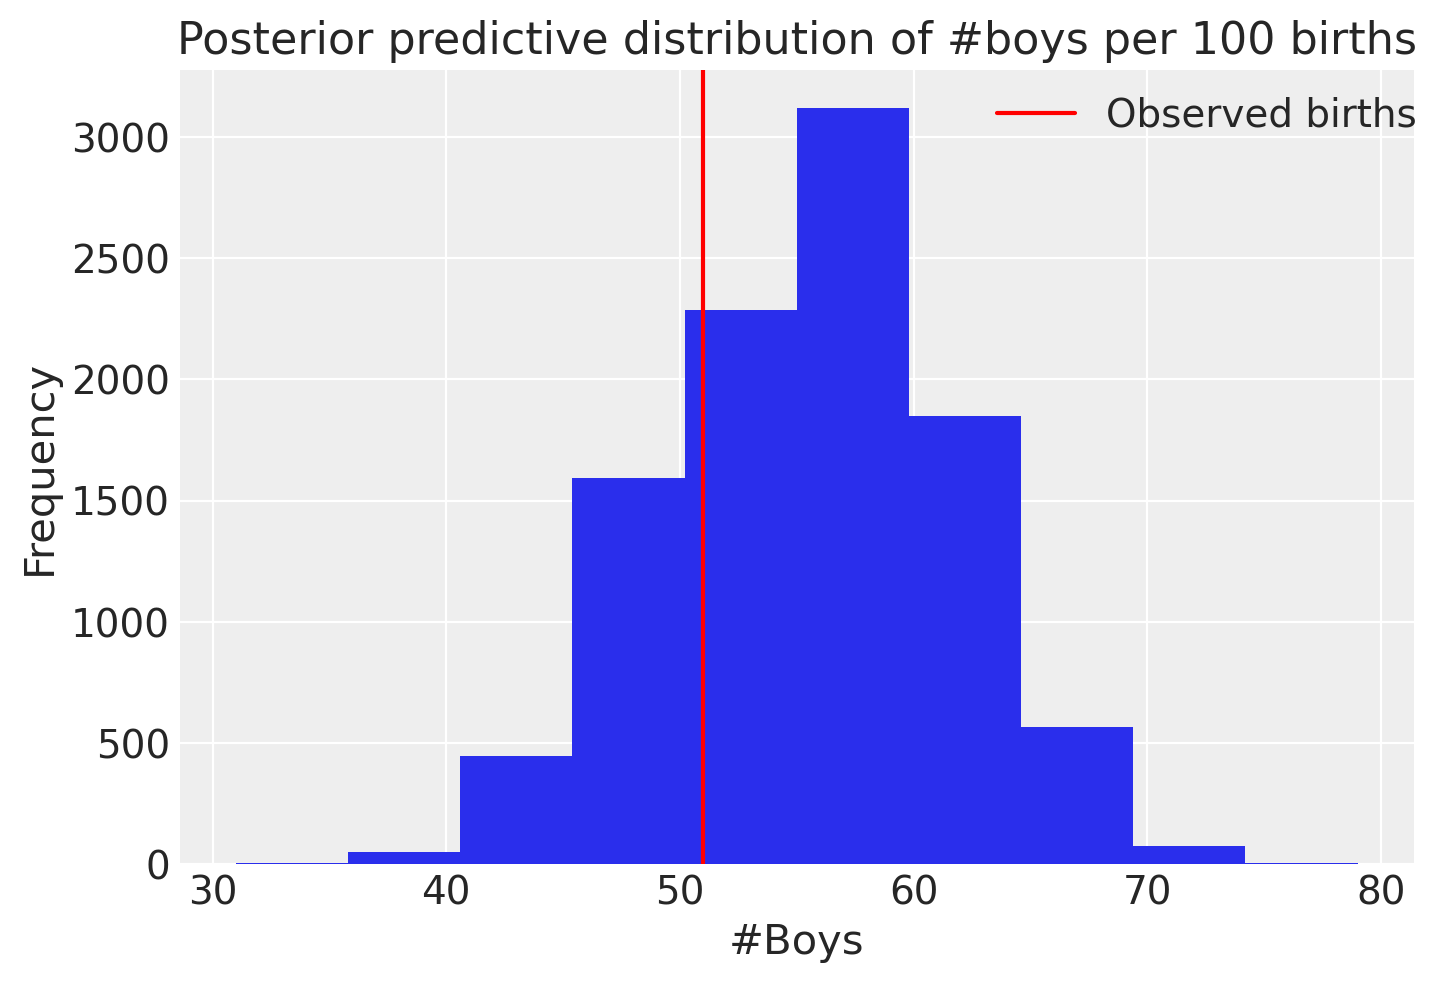

In [51]:
# get the ppd for 100 birth trials
ppd_100 = np.random.binomial(n=100, p=post_sample)
plt.hist(ppd_100)
plt.title("Posterior predictive distribution of #boys per 100 births")
plt.xlabel("#Boys")
plt.ylabel("Frequency")
plt.axvline(np.sum(birth_1), c="r", label="Observed births")
plt.legend(loc=(0.65, 0.9));

As we can see, the observed number of male births in the first births group is consistent with the models own predictions as we would like it to be.

I would say that the model looks perfectly consistent using only this training data.

### **3H5.**
The model assumes that sex of first and second births are independent. To check this assumption, focus now on second births that followed female first borns. Compare 10,000 simulated counts
of boys to only those second births that followed girls. To do this correctly, you need to count the
number of first borns who were girls and simulate that many births, 10,000 times. Compare the
counts of boys in your simulations to the actual observed count of boys following girls. How does the
model look in this light? Any guesses what is going on in these data?

In [52]:
# obtain the number of boys who's births followed girls
print(str(birth_2[birth_1 == 0].sum()) + " male births follow female births")
print(str(birth_2[birth_1 == 0].shape[0]) + " Total female first births")

39 male births follow female births
49 Total female first births


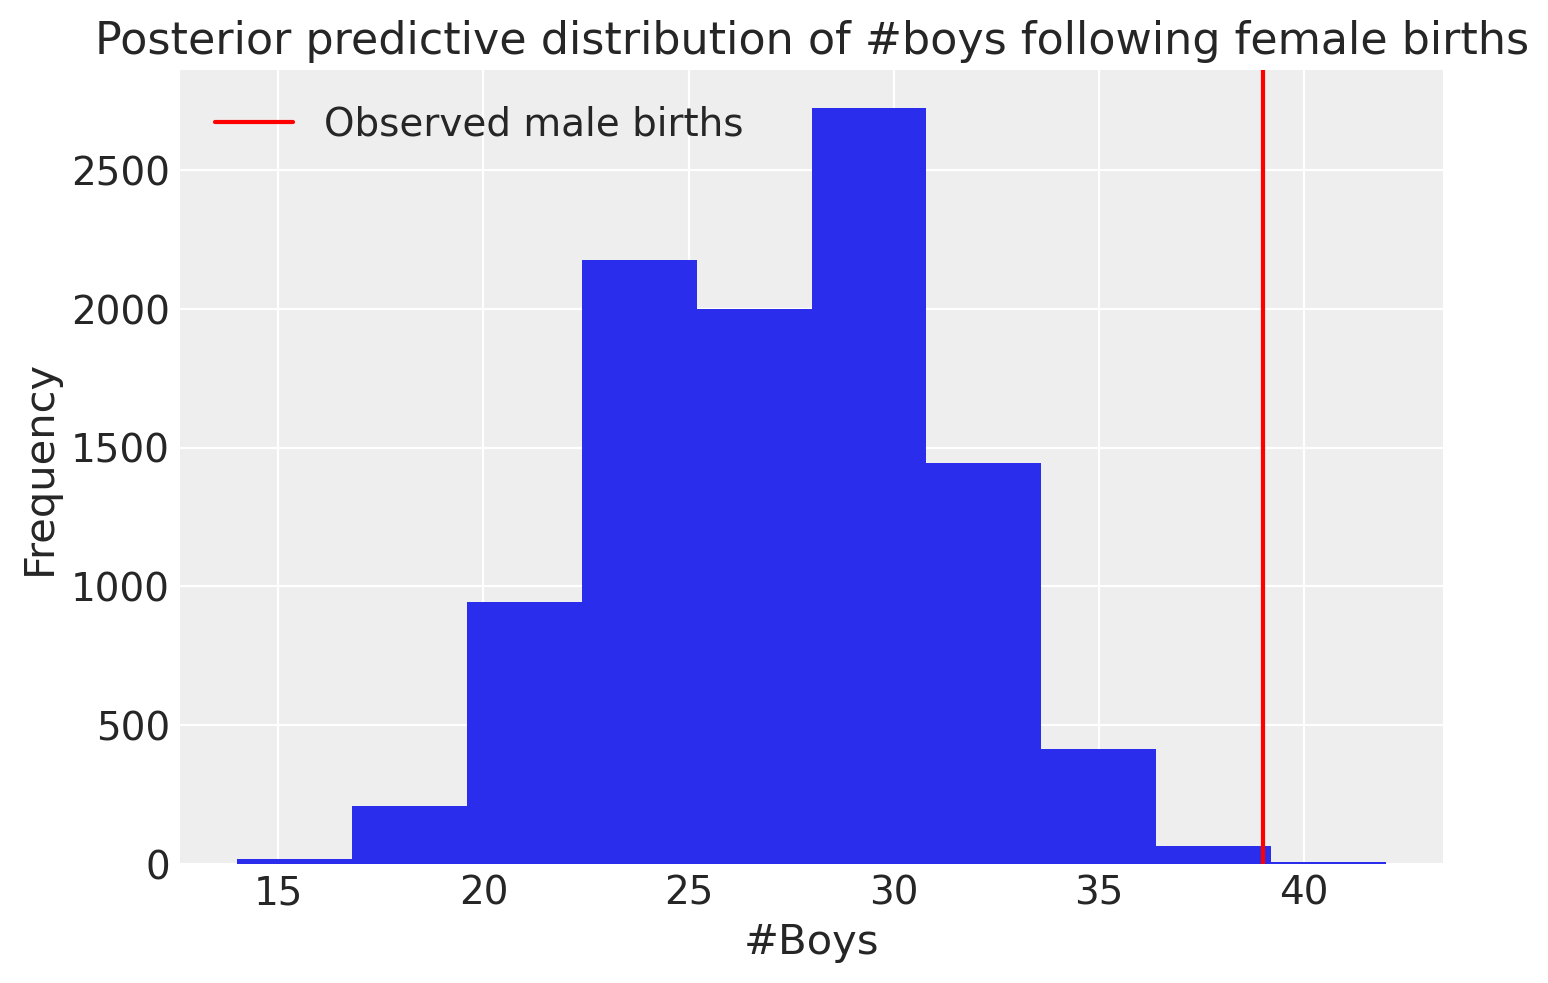

In [54]:
# ppd for male after female (mAf) births
ppd_maf = np.random.binomial(n=49, p=post_sample)
plt.hist(ppd_maf)
plt.title("Posterior predictive distribution of #boys following female births")
plt.xlabel("#Boys")
plt.ylabel("Frequency")
plt.axvline(birth_2[birth_1 == 0].sum(), c="r", label="Observed male births")
plt.legend();

The male births following female births as seen in the data is very different from what the model would have predicted. The likely culprit here is that the model said male and female births were independent. However, this data would imply that once a female has been born you become much more likely to have a male second child, which is in direct conflict with the independence assumption baked into the model. Based on this, one could construct a model of that data which attempts to take the anti-correlated birth gender into account.

In [55]:
%watermark -n -u -v -iv -w

Last updated: Sat Mar 26 2022

Python implementation: CPython
Python version       : 3.9.7
IPython version      : 8.1.1

pymc3     : 3.11.5
arviz     : 0.11.4
sys       : 3.9.7 (default, Sep 16 2021, 13:09:58) 
[GCC 7.5.0]
matplotlib: 3.5.1
numpy     : 1.21.2
scipy     : 1.7.3

Watermark: 2.3.0

